In [1]:
import os.path as op
import sys
sys.path.append(op.abspath('../../'))

sys.path.append(op.abspath('../../../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../../../')

# Replace BDTs by cuts 

The purpose of this notebook is to replace BDTs using cuts.
We use a simulated sample with equal proportion of signal, noise and peaked background.

## Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import models
import var, fcts

from project import files, defs, col
from lib import data, plot as lp

from sklearn.cluster import KMeans

## Simulation

### Parameters

In [3]:
N = 100000
S = 100000
P = 100000


shift_pedestal = (600, 150)
amp_S = 30  # (25, 5)
std_N = 1.

# Peaked
n_peaks = (1, 6)  # between 1 and 6 peaks / event
amp_P = (1, 30)  # peak amplitude between 1 and 15
length_peaks = (1, 3)  # length of a peak between 1 and 3

shift_pedestal = (600, 150)

optimised = False

components = {
    "S": {"S": S, "amp_S": amp_S, "true_pedestal": True},
    "N": {"N": N, "std_N": std_N},
    "P": {
        "P": P, "n_peaks": n_peaks,
        "amp_P": amp_P, "length_peaks": length_peaks
    }
}

bdt_name = "BDT_SNP"

image_path = op.join(var.image_path, bdt_name)


In [4]:
rng = np.random.default_rng(12345)

dataframe = models.get_full_dataframe(
    components,
    shift_pedestal=shift_pedestal,
    random_time_shift=True,
    rng=rng
)

dataframe = files.compute_voi(
    dataframe,
    variables=defs.computed_variables +
    ['lower_than_mean_cons', 'larger_than_mean_cons',
     'std_pos', 'std_neg', 'nb_pos', 'nb_neg']
)


Time taken: 1.6325924396514893


In [5]:
columns_already_computed = [
    'pos_max', 'pos_min',
    'std',
    'lower_than_mean_cons', 'larger_than_mean_cons',
    'std_pos', 'std_neg',
    'nb_pos', 'nb_neg',
]

columns_to_compute = [
    'max_m_mean', 'min_m_mean', 'pos_max_m_pos_min',
    'mean_m_pedestal',
    'median_m_mean', 'mean_m_std_m_pedestal',
    'std_pos_m_std_neg',
    'nb_pos_m_nb_neg',
    'min_m_pedestal',
    'max_m_pedestal',
    'min_std_pos_neg',
    'max_std_pos_neg',
    'max_std_pos_neg_m_min_std_pos_neg',
    'min_std_pos_neg_red',
    'mean_m_pedestal_red',
    'max_std_pos_neg_red',
    'max_m_mean_red',
    'max_m_pedestal_red',
    'std_pos_red',
    'std_neg_red',
]


# Get the formula of the columns to compute
formula_columns = col.get_formula_columns(columns_to_compute)
formula_column_labels = col.get_formula_labels(
    columns_to_compute, defs.column_labels
)
column_labels = {**defs.column_labels, **formula_column_labels}

# Compute them
dataframe = data.compute_vals(dataframe, formula_columns)


## Analysis

First, the multi-variate distributions are analysed. We want to see if the clustering is likely to work.

### Tools
Functions used to analyse the distributions.

### Signal vs Peaked
We analyse the variables used for the training of the BDT that tells apart signal and peaked background. The two features of interest (i.e., the ones that were used in the BDT training) are $\langle e \rangle - e_0$ and $\frac{\min\left(\sigma_e^+, \sigma_e^-\right)}{\sigma_e}$.

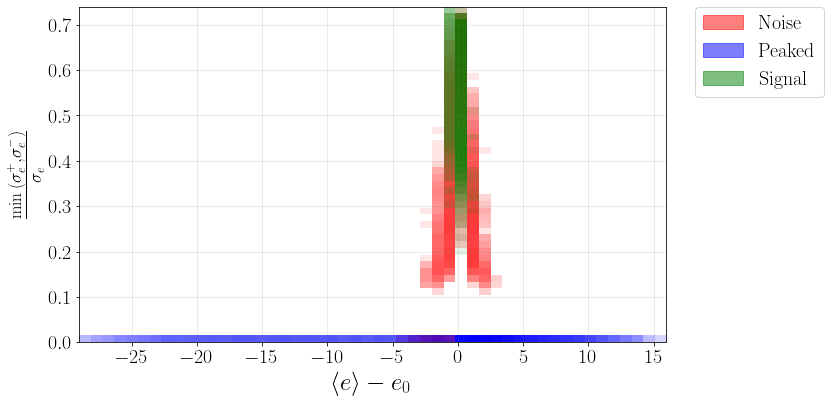

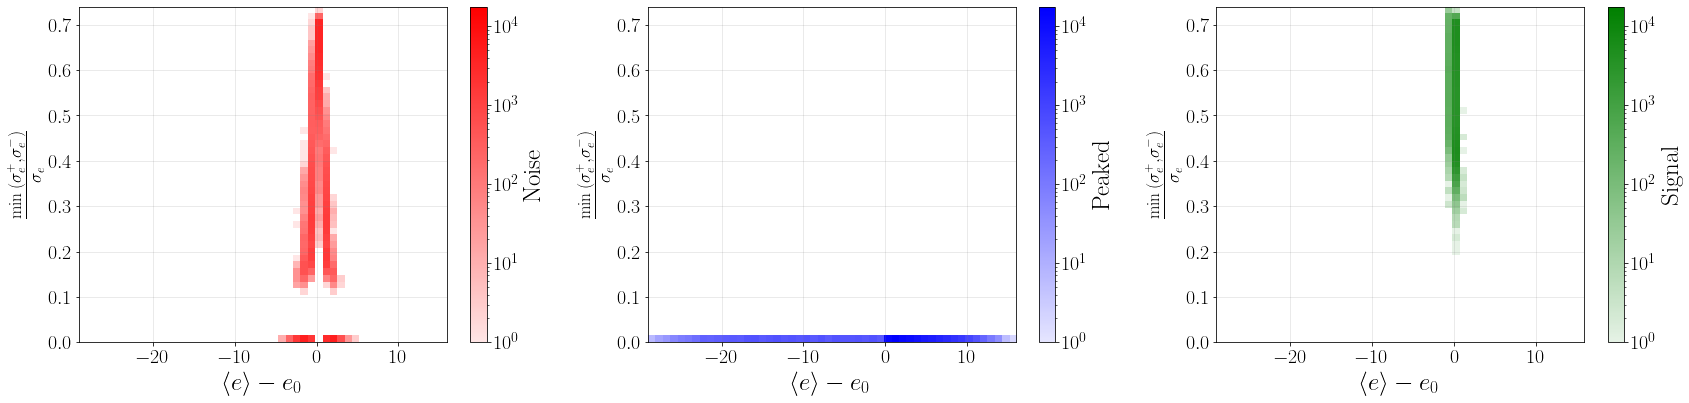

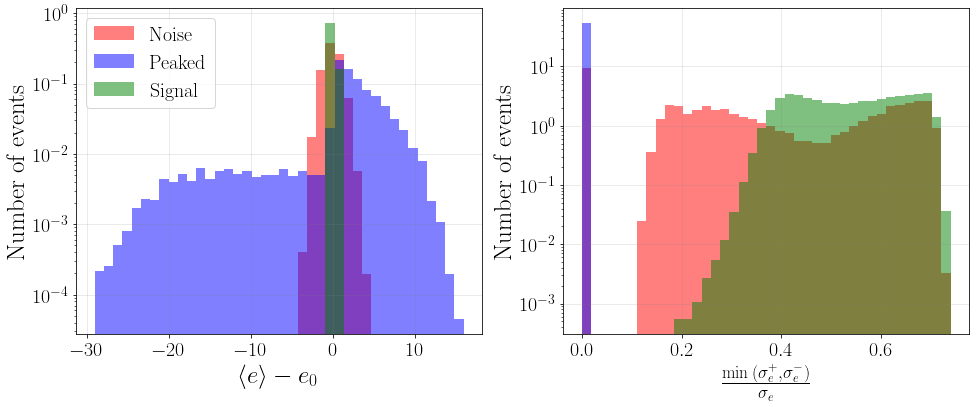

In [6]:
cats = ["S", "P", "N"]

name_var1 = "mean_m_pedestal"
name_var2 = "min_std_pos_neg_red"

fcts.multi_plot_hist2d_cats(
    dataframe, 
    name_var1, name_var2,
    column_labels[name_var1], column_labels[name_var2],
    cats[::-1],
    plot_1d=True
)

We have removed the noise from the pedestal. Thus, there is no signal in $\frac{\min\left(\sigma_e^+, \sigma_e^-\right)}{\sigma_e} < 0.02$, whereas all the peaked background is there.

For the time being, we can perform the cut $\frac{\min\left(\sigma_e^+, \sigma_e^-\right)}{\sigma_e} > 0.02$ to remove the peaked background.

### Signal vs Noise
We analyse the variables used for the training of the BDT that tells apart signal and noise. The two features of interest (i.e., the ones that were used in the BDT training) are $max(e) - \langle e \rangle$ and $\sigma_e$.

We might want to look at $L_-$ and $n_+ - n_-$ as well, but they probably have a misleading behaviour.

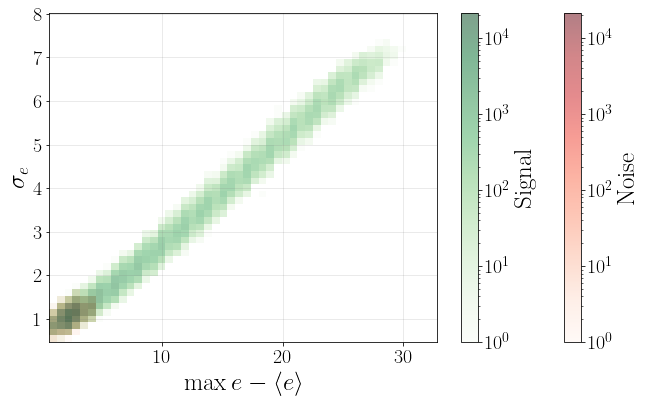

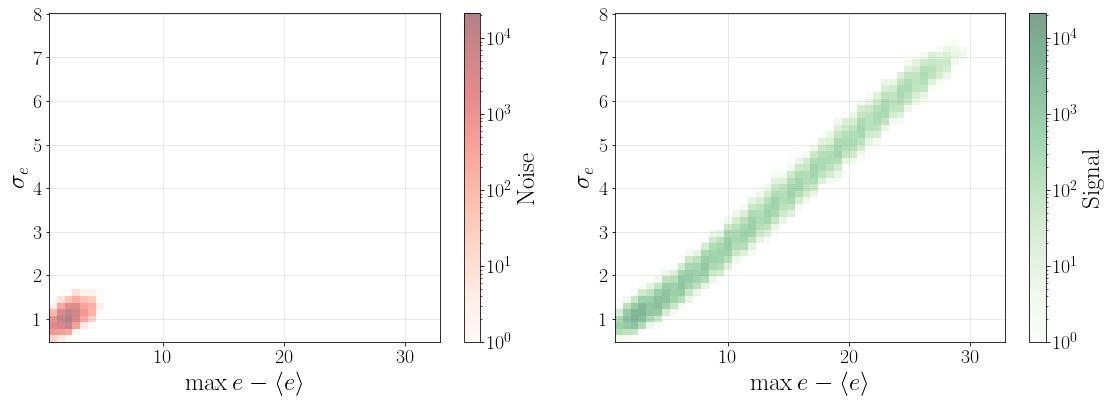

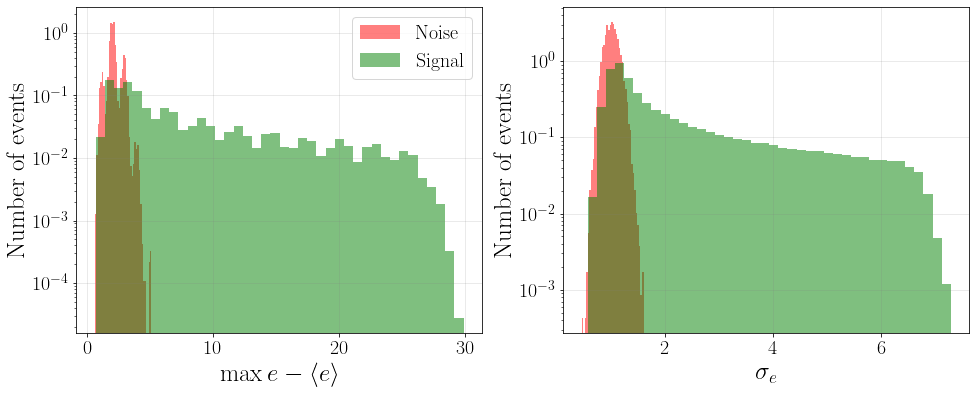

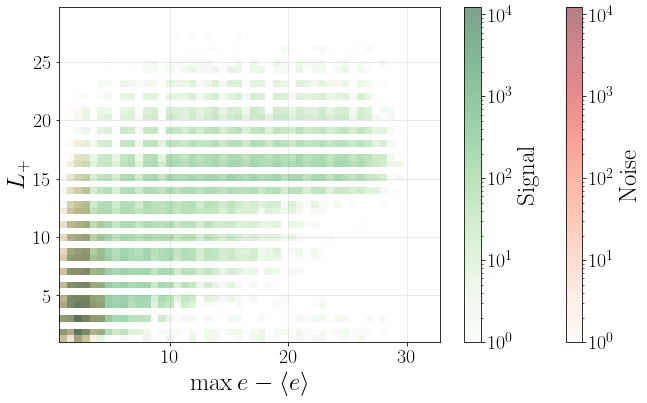

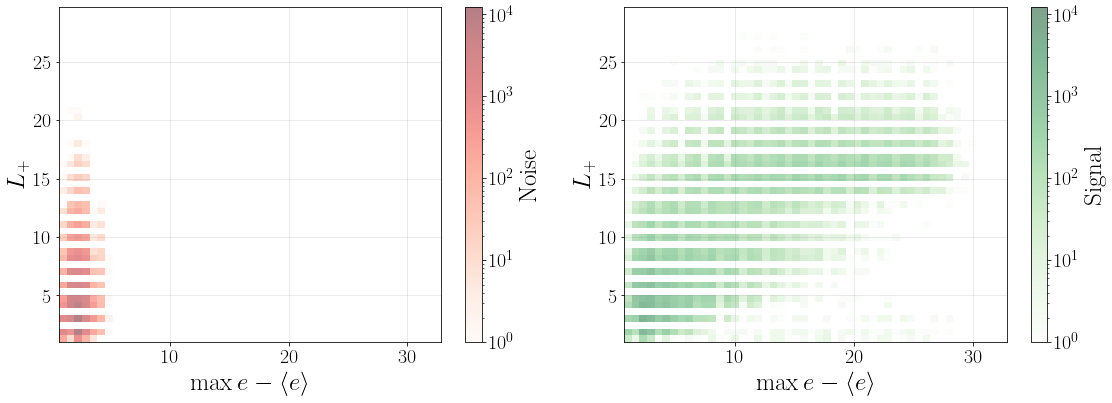

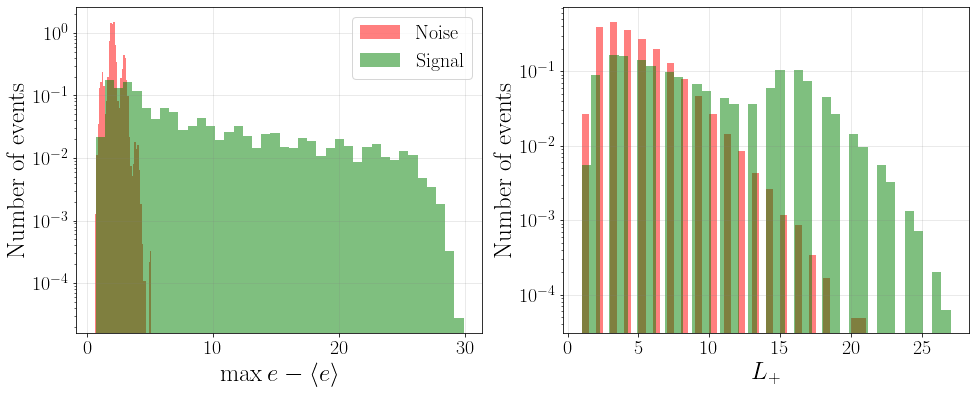

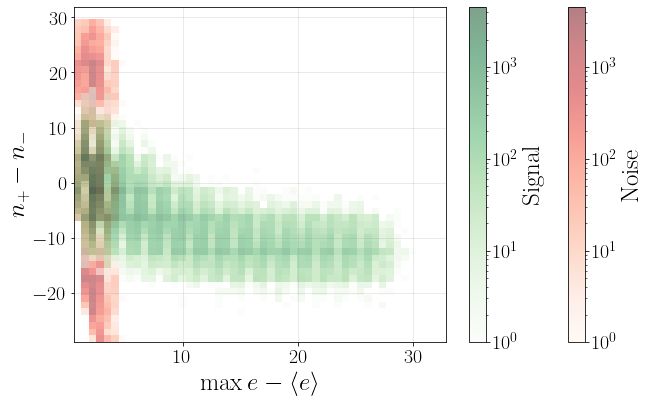

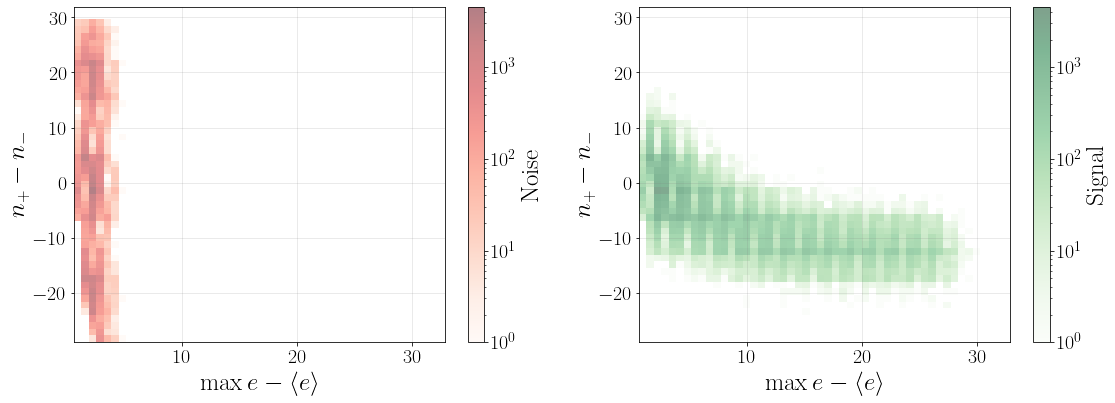

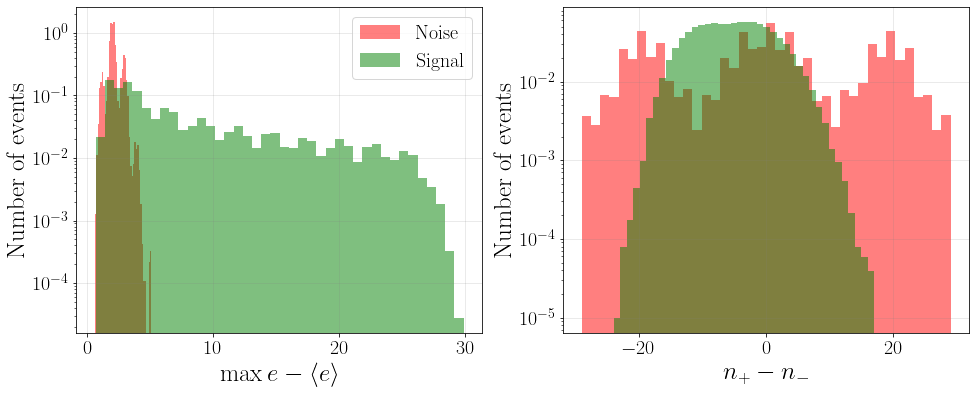

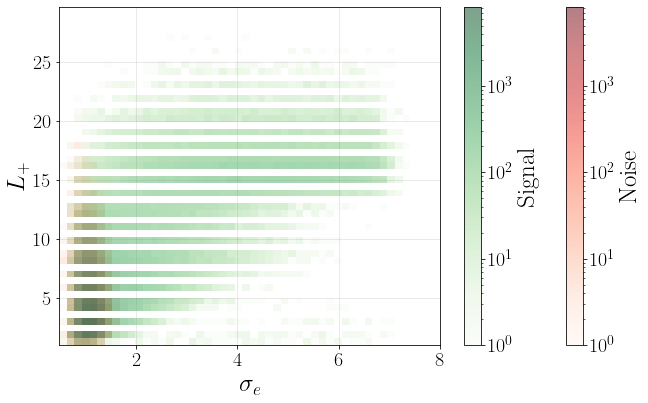

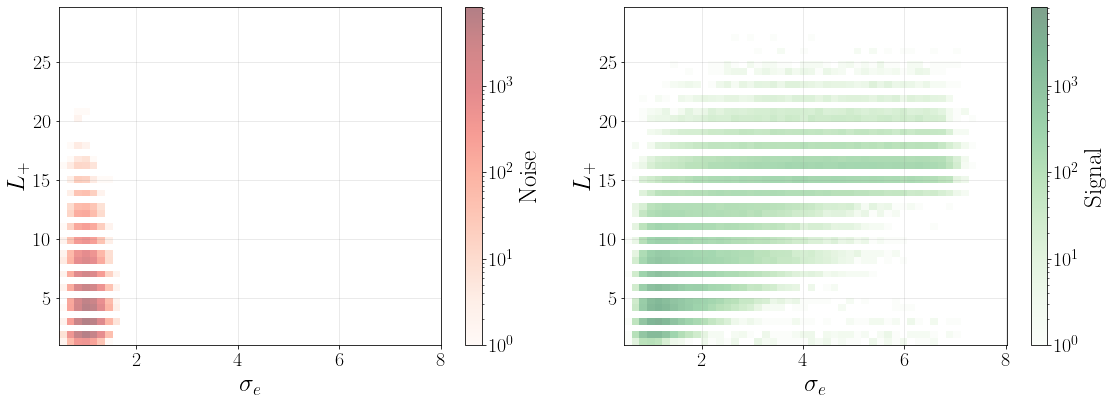

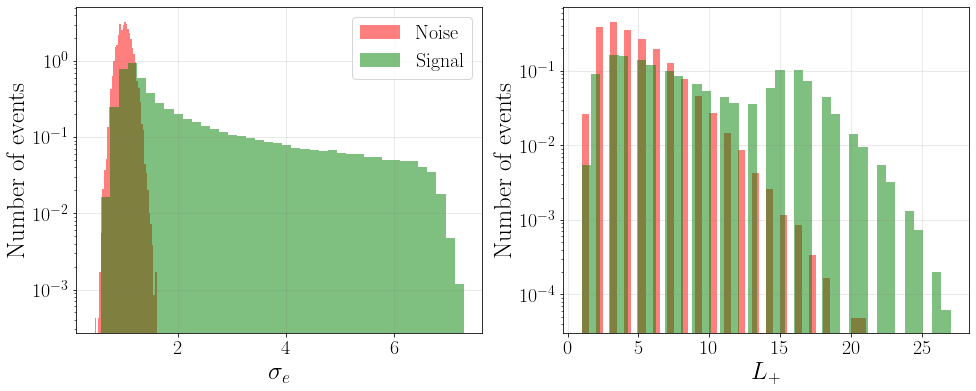

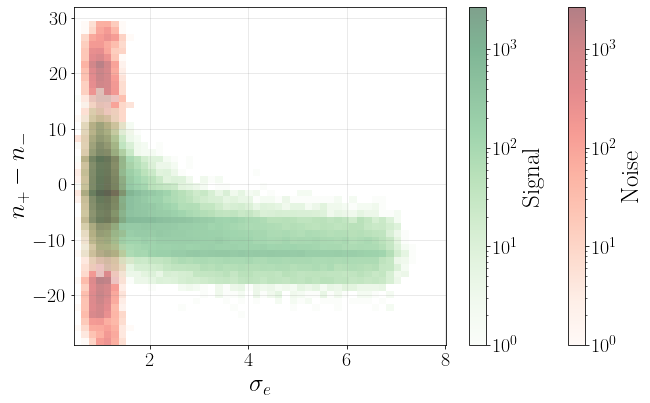

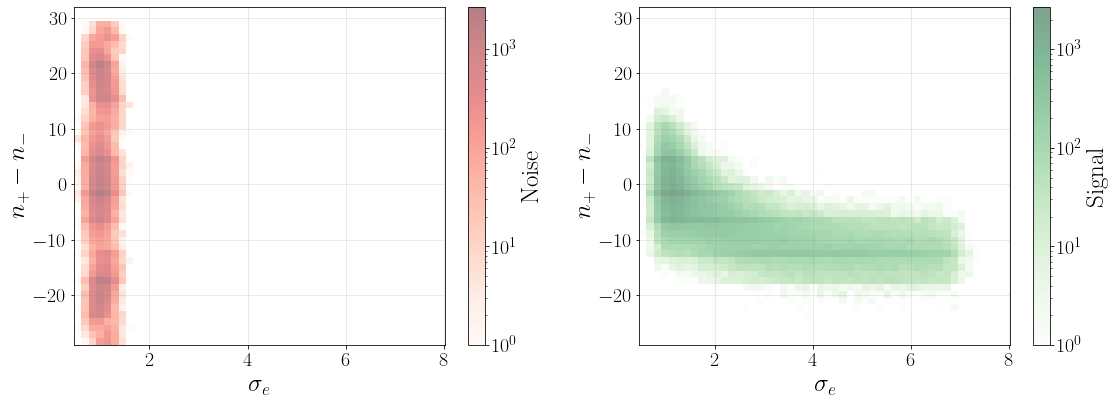

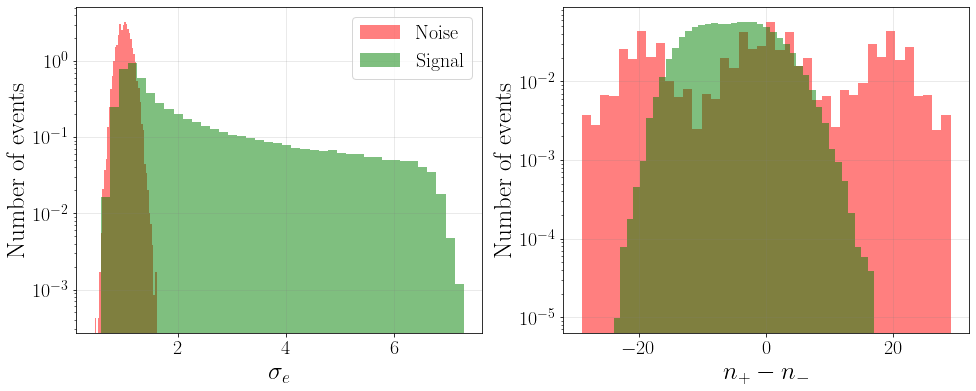

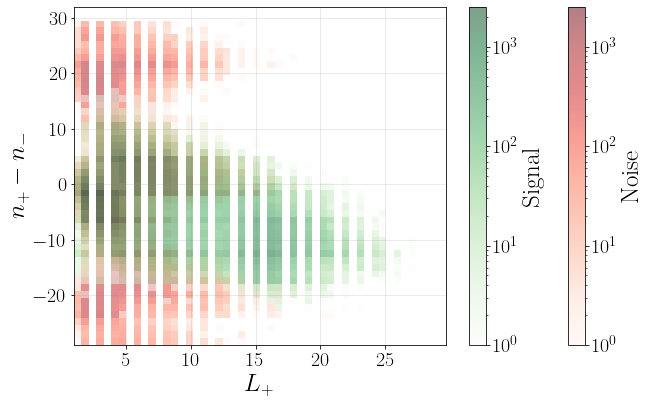

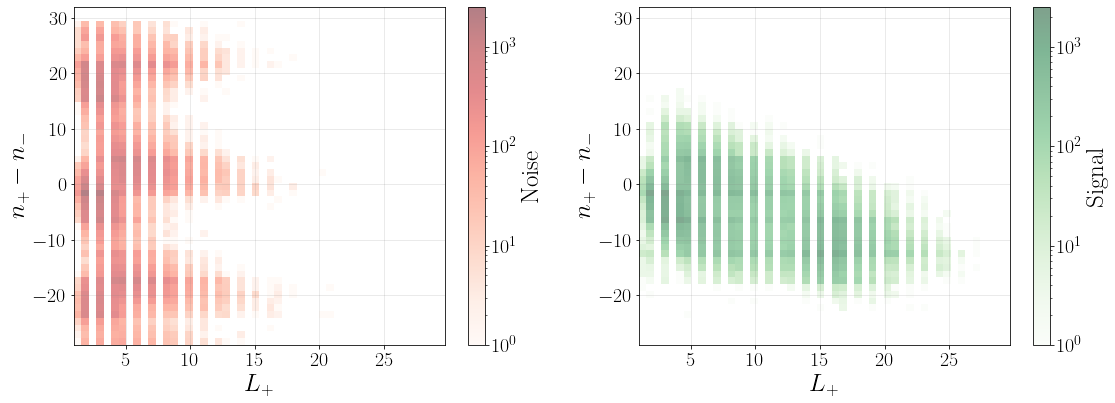

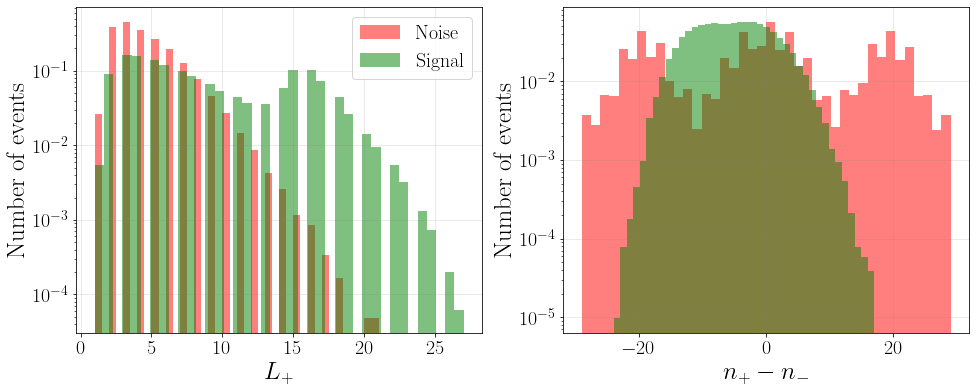

In [7]:
cats = ["S", "N"]

dataframe_no_peaked = dataframe.query("min_std_pos_neg_red > 0.02")

name_var1 = "max_m_mean"
name_var2 = "std"

list_vars = ["max_m_mean", "std", "lower_than_mean_cons", "nb_pos_m_nb_neg"]
# list_vars = ["max_m_mean", "std", "std_pos_red"]
# list_vars = ["max_m_mean", "std"]

import itertools

for combi in itertools.combinations(list_vars, 2):
    fcts.multi_plot_hist2d_cats(
        dataframe_no_peaked, 
        combi[0], combi[1],
        column_labels[combi[0]], column_labels[combi[1]],
        cats[::-1],
        plot_1d=True
    )

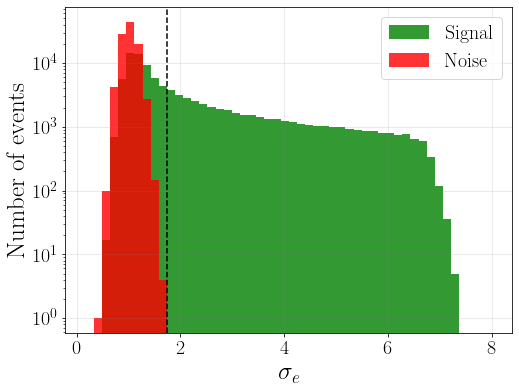

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

feature = "std"

min_max = [dataframe[feature].min(), 8]

for cat in ['S', 'N']:
    dataframe_cat = dataframe.query(f"{var.dict_df_flags[cat]}==True")
    
    lp.plot_hist(
        dataframe_cat[feature],
        column_labels[feature],
        label=var.dict_df_labels[cat],
        color=var.dict_df_colors[cat],
        logscale=True,
        min_max=min_max,
        ax=ax,
        alpha=0.8
    )

ax.axvline(x=1.75, color='k', linestyle='--')
ax.legend()

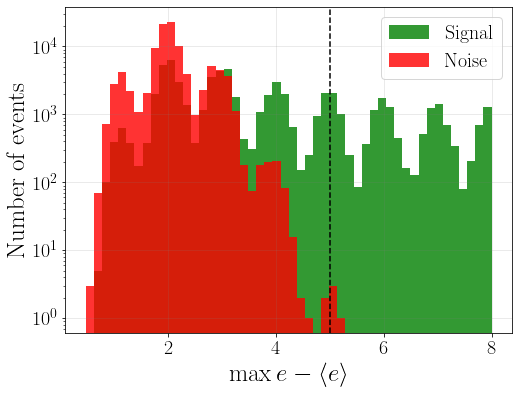

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

feature = "max_m_mean"

min_max = [dataframe[feature].min(), 8]

for cat in ['S', 'N']:
    dataframe_cat = dataframe.query(f"{var.dict_df_flags[cat]}==True")
    
    lp.plot_hist(
        dataframe_cat[feature],
        column_labels[feature],
        label=var.dict_df_labels[cat],
        color=var.dict_df_colors[cat],
        logscale=True,
        min_max=min_max,
        ax=ax,
        alpha=0.8
    )

ax.axvline(x=5, color='k', linestyle='--')
ax.legend()

As we can see, there is a fair amount of noise that can be removed from the sample by using a mere cut in one of the 2 features: $\max(e) - \langle e \rangle$ and $\sigma_e$.

## Clustering : One-dimensional test for Signal vs Peaked

### 

We perform a clustering using only one variable - mainly too see how the clustering behaves.

#### k-means

In [10]:
clu_label_name = "kmeans_SP"
clu_label_alias = "Signal vs Peaked k-means"

In [11]:
features = ["min_std_pos_neg_red"]
cats = ["S", "N", "P"]
dataframe_mixed =  dataframe.sample(n=len(dataframe))
kmeans = KMeans(
    init="k-means++", #algorithm="elkan",
    n_clusters=2, random_state=rng.integers(2**32)
)
kmeans = kmeans.fit(dataframe_mixed[features])
dataframe_mixed[clu_label_name] = kmeans.labels_


/home/anthony/3A_CS/projet_ATLAS/lib/plot.py:185: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$\\frac{\\min{\\left(\\sigma_{+}, \\sigma_{-}\\right)}}{\\sigma_{e}}$', ylabel='Number of events'>)

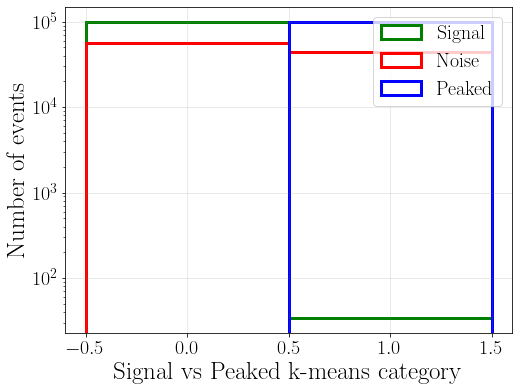

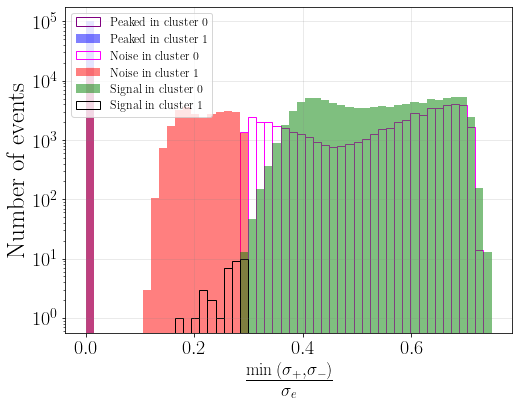

In [12]:
fcts.plot_result_clustering(
    dataframe_mixed,
    clu_label_name,
    clu_label_alias,
    logscale=True,

)

# Correct cluster labels for each category ---------------------------
bkg_clu_label = dataframe_mixed.query(f"{var.dict_df_flags['P']}==True").iloc[0][clu_label_name]
signal_clu_label = 0 if bkg_clu_label == 1 else 1

correct_clu_label_cats = {
    "S": signal_clu_label,
    "P": bkg_clu_label,
    "N": bkg_clu_label,
}

fcts.plot_result_clustering_hist1d(
    dataframe_mixed, features,
    column_labels,
    clu_label_name, correct_clu_label_cats,
    logscale=True,
    cats=cats[::-1]
)